In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac import Node
from podpac import alglib
import traitlets as tl
import logging
import time
import inspect
logger = logging.getLogger('podpac')
logger.setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# Set up the source data Nodes

In [3]:
node = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
node

<Zarr(source='C:\\SMAP.zarr', interpolation='nearest', data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture')>

In [4]:
node_poros = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
node_poros

<Zarr(source='C:\\SMAP_PROPS.zarr', interpolation='nearest', data_key='Land-Model-Constants_Data/clsm_poros')>

In [5]:
node.coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65642547607422, 84.65641784667969], N[1624]
	lon: ArrayCoordinates1d(lon): Bounds[-179.95314025878906, 179.95314025878906], N[3856]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]

## Test source data Node

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source


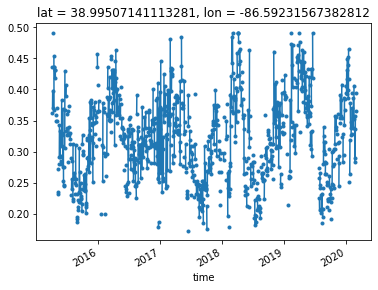

In [6]:
o = node.eval(node.coordinates[300, 1000, :])
o[:, :, :].plot(marker='.')

# Create Coordinates for testing

In [7]:
coords = node.coordinates[300:302, 1000:1002, :]
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]

# Set up Algorithm Node to fit a beta function to the input data for each day of the year

In [8]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

# Test Algorithm Node locally

In [9]:
s = time.time()
o3 = sb.eval(coords)
tot_time = time.time() - s
print("took {}".format(tot_time))

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:podpac.core.algorithm.stats:scale_min: 0
scale_max: <xarray.UnitsDataArray (lat: 2, lon: 2)>
array([[0.46200001, 0.4508    ],
       [0.46200001, 0.46200001]])
Coordinates:
  * lat      (lat) float64 39.0 38.9
  * lon      (lon) float64 -86.59 -86.5
Attributes:
    layer_style:   <podpac.core.style.Style object at 0x000001F7F5478688>
    crs:           EPSG:4326
    geotransform:  (-86.63898086547852, 0.09333038330078125, 0.0, 39.04022789...
DEBUG:podpac.core.algorithm.stats:Working on doy 1 (1/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 2 (2/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 3 (3/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 4 (4/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 5 (5/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 6 (6/366)
DEBUG:podpac.core.

took 12.082530498504639


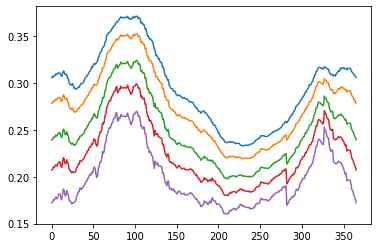

In [10]:
plot((o3)[0, 0, :, 2:].data)

# Setup parallel computation

In [11]:
# Decide chunk size based on 1000 workers and 30% land cover on earth
chunk_size = np.floor(np.sqrt((node.coordinates.shape[0] * node.coordinates.shape[1] * 0.3)  // 1000))
chunk_size

43.0

In [12]:
chunk_size**2*tot_time/4/60  # Expected time to completion in minutes

93.08582871556283

In [13]:
# Too long for 15 minute lambda function, so we'll need multiple 1000's of workers

In [14]:
coords['time'].size

1759

In [15]:
node_p = podpac.managers.Process(source=sb)
# node_p = podpac.managers.Lambda(source=sb)

In [16]:
o = node_p.eval(coords)

DEBUG:podpac.core.managers.multi_process:Starting process.
DEBUG:podpac.core.managers.multi_process:Retrieving data from queue.
DEBUG:podpac.core.managers.multi_process:Joining.
DEBUG:podpac.core.managers.multi_process:Closing.


In [17]:
o

<xarray.UnitsDataArray (lat: 2, lon: 2, time: 366, output: 7)>
array([[[[5.50439911, 2.02140878, 0.30585861, ..., 0.23942725,
          0.20722293, 0.17227949],
         [5.5493379 , 2.04188486, 0.30575489, ..., 0.23963846,
          0.20758017, 0.17277627],
         [5.66365627, 2.05064856, 0.3076822 , ..., 0.24219676,
          0.21034601, 0.17567301],
         ...,
         [5.90599498, 2.14144967, 0.30803761, ..., 0.24407474,
          0.21290397, 0.17886368],
         [5.78862357, 2.10811357, 0.30734212, ..., 0.24268935,
          0.21123073, 0.1769388 ],
         [5.50439911, 2.02140878, 0.30585861, ..., 0.23942725,
          0.20722293, 0.17227949]],

        [[5.84933017, 2.14138242, 0.29948549, ..., 0.23680082,
          0.20630321, 0.17304346],
         [5.88700518, 2.16022435, 0.29932451, ..., 0.23687922,
          0.20649693, 0.17335176],
         [5.89852406, 2.14724502, 0.30015464, ..., 0.23772426,
          0.20731686, 0.17412203],
         ...,
         [6.28972133, 2.25179035, 0.30257136, ..., 0.24223605,
          0.21270259, 0.18027629],
         [6.11992347, 2.22197885, 0.30085054, ..., 0.23967202,
          0.20981244, 0.17712109],
         [5.84933017, 2.14138242, 0.29948549, ..., 0.23680082,
          0.20630321, 0.17304346]]],


       [[[5.24005742, 1.93620026, 0.30460274, ..., 0.2363734 ,
          0.20341738, 0.1678243 ],
         [5.28438665, 1.95518627, 0.3045673 , ..., 0.23666833,
          0.20386084, 0.16840493],
         [5.31590255, 1.93845766, 0.30616986, ..., 0.23837989,
          0.20555292, 0.17002259],
         ...,
         [5.59207664, 2.06084654, 0.30568501, ..., 0.23986221,
          0.20793914, 0.17326381],
         [5.47730149, 2.0335681 , 0.30465153, ..., 0.23812169,
          0.20592255, 0.17102463],
         [5.24005742, 1.93620026, 0.30460274, ..., 0.2363734 ,
          0.20341738, 0.1678243 ]],

        [[6.33562986, 2.72783302, 0.29084675, ..., 0.2306246 ,
          0.20175411, 0.17040428],
         [6.38069849, 2.75246307, 0.29073992, ..., 0.23076541,
          0.2020091 , 0.17077096],
         [6.43639179, 2.75191678, 0.29180881, ..., 0.23203807,
          0.20333853, 0.17212593],
         ...,
         [6.68561009, 2.82956025, 0.29340017, ..., 0.23476409,
          0.20652546, 0.17571486],
         [6.54820471, 2.79481106, 0.29222823, ..., 0.23299804,
          0.20452807, 0.17352462],
         [6.33562986, 2.72783302, 0.29084675, ..., 0.2306246 ,
          0.20175411, 0.17040428]]]])
Coordinates:
  * lat      (lat) float64 39.0 38.9
  * lon      (lon) float64 -86.59 -86.5
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 363.0 364.0 365.0 366.0
  * output   (output) <U2 'a' 'b' 'd0' 'd1' 'd2' 'd3' 'd4'
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001F7F6703C08>
    crs:          EPSG:4326

In [18]:
coords_mp = node.coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]

In [19]:
node_mp = podpac.managers.ParallelOutputZarr(
#     source=node_p, 
    source=sb,
    number_of_workers=4, 
    chunks={'lat': 2, 'lon': 2},
    zarr_file=r'C:\SMAP_CATS.zarr', init_file_mode='a',
    zarr_chunks={'lat': 2, 'lon': 2, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    list_dir=True
)

# Test parallel computation locally using multiple processors

In [20]:
# output = dict(format='zarr_part', 
#               format_kwargs=dict(part=[[0, 2, 1], [0, 2, 1], [0, 366, 1]],
#              source=node_mp.zarr_file,mode="a"))
# o.to_format(output['format'], **output['format_kwargs'])

In [21]:
o_mp = node_mp.eval(coords_mp)

DEBUG:podpac.core.managers.parallel:Creating Zarr file.
DEBUG:podpac.core.managers.parallel:Starting parallel eval.
DEBUG:podpac.core.managers.parallel:Added 0 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(0, 2, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]
DEBUG:podpac.core.managers.parallel:Added 1 to worker pool
DEBUG:podpac.core.managers.parallel:Creating output format.
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(2, 4, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2]
	lon: ArrayCoordinates1d(lon): Bounds[-86.40560913085938, -86.31224822998047], N[2]
	time: Arra

In [22]:
# Check the results
cats = podpac.data.Zarr(
    source=r'C:\SMAP_CATS.zarr',
)
cats

<Zarr(source='C:\\SMAP_CATS.zarr', interpolation='nearest')>

In [23]:
d0 = cats.dataset['d0'][5, 5, :]

In [24]:
cats.dataset['d0'].shape

(6, 6, 366)

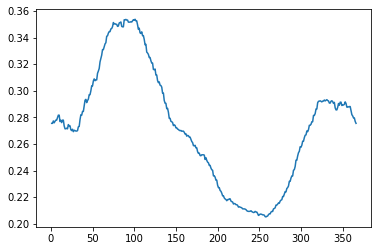

In [25]:
plot(cats.dataset['time'], d0.reshape(-1, 366).T)
pass

In [26]:
list(cats.dataset.keys())

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4', 'lat', 'lon', 'time']

In [27]:
cats.coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6]
	time: ArrayCoordinates1d(time): Bounds[1.0, 366.0], N[366]

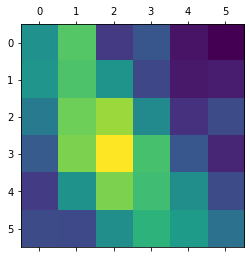

In [29]:
a = cats.dataset['a'][:].mean(axis=2)
matshow(a)

# Test on AWS

In [3]:
settings = {
    "FUNCTION_NAME": "podpac-drought-monitor-lambda-compute-stats",
    "S3_BUCKET_NAME": "podpac-drought-monitor-s3",
    "FUNCTION_ROLE_NAME": "podpac-drought-monitor-role",
    "MULTITHREADING": True,
    "N_THREADS": 64,
    "AWS_ACCESS_KEY_ID": podpac.settings["AWS_ACCESS_KEY_ID"],
    "AWS_SECRET_ACCESS_KEY": podpac.settings["AWS_SECRET_ACCESS_KEY"],
    "AWS_REGION_NAME": podpac.settings["AWS_REGION_NAME"],
    "AWS_BUDGET_AMOUNT": 100,
    "AWS_BUDGET_EMAIL": podpac.settings["AWS_BUDGET_EMAIL"],
    "FUNCTION_DEPENDENCIES_KEY": "podpac_deps.zip",
}
podpac.settings.update(settings)
# settings

In [4]:
node = podpac.data.Zarr(
    source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node

In [5]:
node_poros = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node_poros

In [6]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

In [7]:
coords = node.coordinates[300:302, 1000:1002, :]
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]

In [8]:
coords_mp = node.coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6]
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6]
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759]

In [9]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=60*15,
)

In [10]:
node_p.get_budget()
node_p.describe()

DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-compute-stats-budget



Lambda Node (staged)
    Function
        Name: podpac-drought-monitor-lambda-compute-stats
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: None
        Triggers: ['eval']
        Handler: handler.handler
        Environment Variables: {}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {}
        Source Dist: s3://podpac-dist/dev/podpac_dist.zip
        Source Dependencies: s3://podpac-dist/dev/podpac_deps.zip
        Last Modified: None
        Version: None
        Restrict Evaluation: []

    S3
        Bucket: podpac-drought-monitor-s3
        Tags: {}
        Input Folder: input/
        Output Folder: output/

    Role
        Name: podpac-drought-monitor-role
        Description: PODPAC Lambda Role
        ARN: None
        Policy Document: {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Action': ['s3:PutObject', 's3:GetObject', 's3:DeleteObject', 's3:ReplicateObject', 's3:ListBucket', 's3:ListMultipartUploadParts', 

In [11]:
# o = podpac.Node.from_json(node_p.json).eval(coords)  #Check! Works well

In [12]:
start = time.time()
i = 2
coords = node.coordinates[300:302 + i, 1000:1002 + i, :]
o = node_p.eval(coords)
tot_time = time.time() - start
print(tot_time)
o.shape

DEBUG:podpac.core.managers.aws:Evaluating pipeline via invoke synchronously
DEBUG:podpac.core.managers.aws:Received response from lambda function


87.44453978538513


(4, 4, 366, 7)

In [13]:
np.sqrt(60*15 / (72 / i **2))

7.0710678118654755

In [14]:
o

<xarray.UnitsDataArray (lat: 4, lon: 4, time: 366, output: 7)>
array([[[[ 5.50439911,  2.02140878,  0.30585861, ...,  0.23942725,
           0.20722293,  0.17227949],
         [ 5.5493379 ,  2.04188486,  0.30575489, ...,  0.23963846,
           0.20758017,  0.17277627],
         [ 5.66365627,  2.05064856,  0.3076822 , ...,  0.24219676,
           0.21034601,  0.17567301],
         ...,
         [ 5.90599498,  2.14144967,  0.30803761, ...,  0.24407474,
           0.21290397,  0.17886368],
         [ 5.78862357,  2.10811357,  0.30734212, ...,  0.24268935,
           0.21123073,  0.1769388 ],
         [ 5.50439911,  2.02140878,  0.30585861, ...,  0.23942725,
           0.20722293,  0.17227949]],

        [[ 5.84933017,  2.14138242,  0.29948549, ...,  0.23680082,
           0.20630321,  0.17304346],
         [ 5.88700518,  2.16022435,  0.29932451, ...,  0.23687922,
           0.20649693,  0.17335176],
         [ 5.89852406,  2.14724502,  0.30015464, ...,  0.23772426,
           0.20731686,  0.17412203],
         ...,
         [ 6.28972133,  2.25179035,  0.30257136, ...,  0.24223605,
           0.21270259,  0.18027629],
         [ 6.11992347,  2.22197885,  0.30085054, ...,  0.23967202,
           0.20981244,  0.17712109],
         [ 5.84933017,  2.14138242,  0.29948549, ...,  0.23680082,
           0.20630321,  0.17304346]],

        [[ 4.65429591,  1.0981486 ,  0.3039305 , ...,  0.23839061,
           0.20484196,  0.16779175],
         [ 4.65429591,  1.0981486 ,  0.3039305 , ...,  0.23839061,
           0.20484196,  0.16779175],
         [ 4.75085929,  1.09966555,  0.30555667, ...,  0.24081861,
           0.20755406,  0.17069272],
         ...,
         [ 4.77469367,  1.0488335 ,  0.3097186 , ...,  0.24521774,
           0.21179033,  0.17457584],
         [ 4.84104307,  1.10583058,  0.30668318, ...,  0.2426758 ,
           0.2096968 ,  0.17305299],
         [ 4.65429591,  1.0981486 ,  0.3039305 , ...,  0.23839061,
           0.20484196,  0.16779175]],

        [[ 4.76970282,  1.17152507,  0.30076673, ...,  0.23619176,
           0.20331393,  0.16703916],
         [ 4.76970282,  1.17152507,  0.30076673, ...,  0.23619176,
           0.20331393,  0.16703916],
         [ 4.99297084,  1.1707122 ,  0.30473378, ...,  0.24188382,
           0.20960049,  0.17370963],
         ...,
         [ 4.29661954,  0.98794454,  0.30573452, ...,  0.2369777 ,
           0.20174724,  0.16305921],
         [ 4.54337008,  1.09574193,  0.30203856, ...,  0.2355561 ,
           0.20167717,  0.1644127 ],
         [ 4.76970282,  1.17152507,  0.30076673, ...,  0.23619176,
           0.20331393,  0.16703916]]],


       [[[ 5.24005742,  1.93620026,  0.30460274, ...,  0.2363734 ,
           0.20341738,  0.1678243 ],
         [ 5.28438665,  1.95518627,  0.3045673 , ...,  0.23666833,
           0.20386084,  0.16840493],
         [ 5.31590255,  1.93845766,  0.30616986, ...,  0.23837989,
           0.20555292,  0.17002259],
         ...,
         [ 5.59207664,  2.06084654,  0.30568501, ...,  0.23986221,
           0.20793914,  0.17326381],
         [ 5.47730149,  2.0335681 ,  0.30465153, ...,  0.23812169,
           0.20592255,  0.17102463],
         [ 5.24005742,  1.93620026,  0.30460274, ...,  0.2363734 ,
           0.20341738,  0.1678243 ]],

        [[ 6.33562986,  2.72783302,  0.29084675, ...,  0.2306246 ,
           0.20175411,  0.17040428],
         [ 6.38069849,  2.75246307,  0.29073992, ...,  0.23076541,
           0.2020091 ,  0.17077096],
         [ 6.43639179,  2.75191678,  0.29180881, ...,  0.23203807,
           0.20333853,  0.17212593],
         ...,
         [ 6.68561009,  2.82956025,  0.29340017, ...,  0.23476409,
           0.20652546,  0.17571486],
         [ 6.54820471,  2.79481106,  0.29222823, ...,  0.23299804,
           0.20452807,  0.17352462],
         [ 6.33562986,  2.72783302,  0.29084675, ...,  0.2306246 ,
           0.20175411,  0.17040428]],

        [[ 6.11635353,  2.31342851,  0.30408004, ...,  0.24163576,
           0.21130691,  0.17

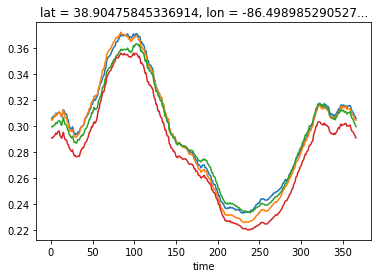

In [15]:
o[0, 0, :, 2].plot()
o[1, 0, :, 2].plot()
o[0, 1, :, 2].plot()
o[1, 1, :, 2].plot()

# Test on AWS in parallel

In [37]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=1.25,  # This is dependent on my internet connection and AWS' response time.
    download_result=True  # This is the default anyway...
)

In [42]:
# Test Async Exception -- Trying to figure out what the exception should be
# import botocore
# for i in range(6):
#     print(i)
#     try:
#         o=node_p.eval(coords)
#     except botocore.exceptions.ReadTimeoutError:
#         pass

In [38]:
coords_mp = node.coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [39]:
node_mp = podpac.core.managers.parallel.ParallelAsyncOutputZarr(
    source=node_p, 
    number_of_workers=2, 
    chunks={'lat': 2, 'lon': 2},
    zarr_file=r's3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr', init_file_mode='a',
    zarr_chunks={'lat': 2, 'lon': 2, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    list_dir=True
)

In [40]:
o_mp = node_mp.eval(coords_mp)

DEBUG:podpac.core.managers.parallel:Creating Zarr file.
DEBUG:podpac.core.managers.parallel:Starting parallel eval.
DEBUG:podpac.core.managers.parallel:Added 0 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(0, 2, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']
DEBUG:podpac.core.managers.parallel:Added 1 to worker pool
INFO:podpac.core.managers.parallel:Skipping 0 (already exists)
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(2, 4, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordina

I somehow have to clear the Zarr cache but I haven't figured out how to do that... 
so i restart to check the results

In [41]:
# Check the results
cats = podpac.data.Zarr(
    # For some reason I only get Nans for this, maybe a permission error?
    source=r's3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr',  
#     source=r'C:\SMAP_CATS_TEST.zarr',  # I downloaded this to check, and the data is just fine
    file_mode='a'
)
cats

<Zarr(source='s3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr', interpolation='nearest')>

In [42]:
cats.available_data_keys

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4']

In [43]:
d0 = cats.dataset['d0'][:6, :6, :]

In [44]:
cats.dataset['d0'].shape

(6, 6, 366)

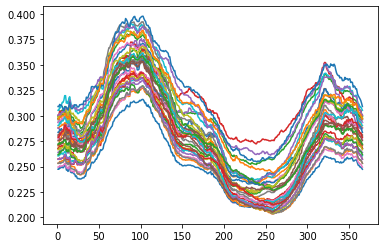

In [45]:
plot(cats.dataset['time'], d0.reshape(-1, 366).T)
pass

In [46]:
np.nanmax(d0)

0.3978528286574542

In [47]:
list(cats.dataset.keys())

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4', 'lat', 'lon', 'time']

In [48]:
cats.coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[1.0, 366.0], N[366], ctype['midpoint']

In [49]:
node_p.get_budget()

DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-compute-stats-budget


{'BudgetName': 'podpac-drought-monitor-lambda-compute-stats-budget',
 'BudgetLimit': {'Amount': '500.0', 'Unit': 'USD'},
 'CostFilters': {'Service': ['AWS Lambda'],
  'TagKeyValue': ['user:_podpac_resource_hash$013285c69752c615135a48f1f1362cae']},
 'CostTypes': {'IncludeTax': True,
  'IncludeSubscription': True,
  'UseBlended': False,
  'IncludeRefund': False,
  'IncludeCredit': False,
  'IncludeUpfront': True,
  'IncludeRecurring': True,
  'IncludeOtherSubscription': True,
  'IncludeSupport': True,
  'IncludeDiscount': True,
  'UseAmortized': False},
 'TimeUnit': 'MONTHLY',
 'TimePeriod': {'Start': datetime.datetime(2020, 3, 31, 20, 0, tzinfo=tzlocal()),
  'End': datetime.datetime(2087, 6, 14, 20, 0, tzinfo=tzlocal())},
 'CalculatedSpend': {'ActualSpend': {'Amount': '1252.85', 'Unit': 'USD'}},
 'BudgetType': 'COST',
 'LastUpdatedTime': datetime.datetime(2020, 4, 20, 1, 37, 22, 519000, tzinfo=tzlocal())}

# Do the computation for the whole world!
Delete the SMAP_CATS zarr file that exists on S3 before continuing here.

I found that Jupyter would hang because the log file gets too big. so I run a similar script from the commandline instead. 

In [23]:
%pylab widget

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac import Node
from podpac import alglib
import traitlets as tl
import logging
import time
import inspect
logger = logging.getLogger('podpac')
logger.setLevel(logging.INFO)

In [3]:
from podpac.utils import create_logfile

In [4]:
create_logfile(r'D:\smap_cats_compute_4.log')

INFO:podpac.core.utils:Logging to file D:\smap_cats_compute_4.log


(<Logger podpac (INFO)>,
 <FileHandler D:\smap_cats_compute_4.log (NOTSET)>,
 <logging.Formatter at 0x1d4d643fc48>)

In [3]:
settings = {
    "FUNCTION_NAME": "podpac-drought-monitor-lambda-compute-stats",
    "S3_BUCKET_NAME": "podpac-drought-monitor-s3",
    "FUNCTION_ROLE_NAME": "podpac-drought-monitor-role",
    "MULTITHREADING": True,
    "N_THREADS": 64,
    "AWS_ACCESS_KEY_ID": podpac.settings["AWS_ACCESS_KEY_ID"],
    "AWS_SECRET_ACCESS_KEY": podpac.settings["AWS_SECRET_ACCESS_KEY"],
    "AWS_REGION_NAME": podpac.settings["AWS_REGION_NAME"],
    "AWS_BUDGET_AMOUNT": 100,
    "AWS_BUDGET_EMAIL": podpac.settings["AWS_BUDGET_EMAIL"],
    "FUNCTION_DEPENDENCIES_KEY": "podpac_deps.zip",
}
podpac.settings.update(settings)
# settings

In [6]:
N_WORKERS = 100

In [7]:
node = podpac.data.Zarr(
    source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True,
)
# node

In [8]:
node_poros = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node_poros

In [9]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

In [10]:
coords_mp = node.coordinates#.select({"lat": [], "lon": []})
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65642547607422, 84.65641784667969], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95314025878906, 179.95314025878906], N[3856], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [11]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=1.25
)

In [12]:
node_mp = podpac.core.managers.parallel.ParallelAsyncOutputZarr(
    source=node_p, 
    number_of_workers=N_WORKERS,
    chunks={'lat': 8, 'lon': 8},
    zarr_file=r's3://podpac-drought-monitor-s3/SMAP_CATS.zarr', init_file_mode='a',
    zarr_chunks={'lat': 8, 'lon': 8, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    aws_config_kwargs=dict(max_pool_connections=N_WORKERS*10),  # This is needed to avoid a warning about the number of open connections
    start_i = 20100  # I was developing the software as I was doing this computation, so I made improvements along the way and did not want to start over
)
node_mp

<ParallelAsyncOutputZarr(source=Lambda (staged)
	Name: podpac-drought-monitor-lambda-compute-stats
	Source: BetaFitDayOfYear
	Bucket: podpac-drought-monitor-s3
	Triggers: ['eval']
	Role: podpac-drought-monitor-role
, number_of_workers=100, chunks={'lat': 8, 'lon': 8})>

In [ ]:
o_mp = node_mp.eval(coords_mp)

INFO:podpac.core.managers.parallel:Submitting source 20104
INFO:podpac.core.managers.parallel:Submitting source 20117
INFO:podpac.core.managers.parallel:Submitting source 20100
INFO:podpac.core.managers.parallel:Submitting source 20112
INFO:podpac.core.managers.parallel:Submitting source 20113
INFO:podpac.core.managers.parallel:Submitting source 20118
INFO:podpac.core.managers.parallel:Submitting source 20103
INFO:podpac.core.managers.parallel:Submitting source 20105
INFO:podpac.core.managers.parallel:Submitting source 20120
INFO:podpac.core.managers.parallel:Submitting source 20200
INFO:podpac.core.managers.parallel:Submitting source 20201
INFO:podpac.core.managers.parallel:Submitting source 20109
INFO:podpac.core.managers.parallel:Submitting source 20102
INFO:podpac.core.managers.parallel:Submitting source 20115
INFO:podpac.core.managers.parallel:Submitting source 20125
INFO:podpac.core.managers.parallel:Submitting source 20114
INFO:podpac.core.managers.parallel:Submitting source 201

In [4]:
# Check the results
cats = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_CATS.zarr',
)
cats

<Zarr(source='s3://podpac-drought-monitor-s3/SMAP_CATS.zarr', interpolation='nearest')>

In [5]:
d0 = cats.dataset['d0'][:, :, 128]

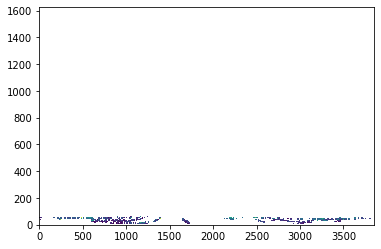

In [6]:
pcolormesh(d0)